In [4]:
import numpy as np
import matplotlib.pyplot as plt

def output(filename):
    return f"../figs/{filename}"

In [5]:
t = np.linspace(0, 2*np.pi, 1000)
x = np.sin(t)
y = np.cos(t)

plt.figure(figsize=(5,5))
# plt.tight_layout()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(output("test.png"), bbox_inches='tight')


## Simulation in Python

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Initialization of the XY-Model:

In [7]:
def init_spins(Lx, Ly, aligned=False, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    if aligned:
        angle = rng.random() * 2*np.pi
        return np.full((Ly, Lx), angle, dtype=np.float64)
    return rng.random((Ly, Lx)) * 2*np.pi

def magnetization(spins):
    mx = np.cos(spins).sum()
    my = np.sin(spins).sum()
    return np.hypot(mx, my) / spins.size

def energy_per_spin(spins):
    # E = - sum_<ij> cos(theta_i - theta_j) / N
    # periodic BC via np.roll; count each bond once: right + down
    right = np.roll(spins, -1, axis=1)
    down  = np.roll(spins, -1, axis=0)
    E = -(np.cos(spins - right) + np.cos(spins - down)).sum()
    return E / spins.size


### Metropolis Sweep

In [8]:
def metropolis_sweep(spins, T, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    H, W = spins.shape

    up    = np.roll(spins, -1, axis=0)
    down  = np.roll(spins,  1, axis=0)
    right = np.roll(spins, -1, axis=1)
    left  = np.roll(spins,  1, axis=1)

    E_now = -(np.cos(spins-up)+np.cos(spins-down)+np.cos(spins-right)+np.cos(spins-left))

    delta = rng.random((H, W)) * 2*np.pi
    spins_new = (spins + delta) % (2*np.pi)

    upn    = np.roll(spins_new, -1, axis=0)
    downn  = np.roll(spins_new,  1, axis=0)
    rightn = np.roll(spins_new, -1, axis=1)
    leftn  = np.roll(spins_new,  1, axis=1)
    E_after = -(np.cos(spins_new-upn)+np.cos(spins_new-downn)+np.cos(spins_new-rightn)+np.cos(spins_new-leftn))

    dE = E_after - E_now
    accept = (dE < 0) | (rng.random((H, W)) < np.exp(-dE / T))
    return np.where(accept, spins_new, spins)


In [9]:
# --- Cell 4: run + record observables vs. steps ---
L = 64
T = 1.0
rng = np.random.default_rng(0)

spins = init_spins(L, L, aligned=False, rng=rng)

n_burn = 200
n_steps = 1000

# burn-in
for _ in range(n_burn):
    spins = metropolis_sweep(spins, T, rng=rng)

Ms, Es = [], []
for _ in range(n_steps):
    spins = metropolis_sweep(spins, T, rng=rng)
    Ms.append(magnetization(spins))
    Es.append(energy_per_spin(spins))

print("M mean:", np.mean(Ms))
print("E mean:", np.mean(Es))


M mean: 0.025117480268712578
E mean: -0.5175183098995849


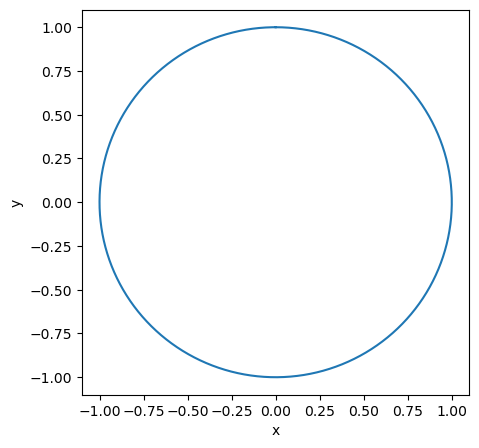

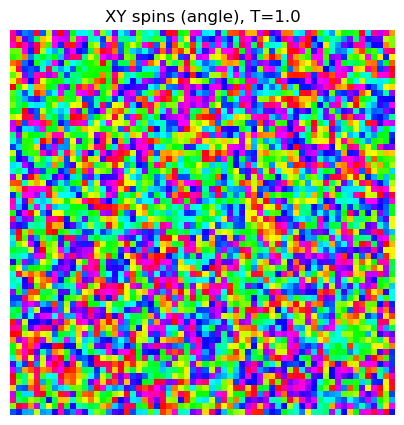

In [10]:
# --- Cell 5: visualize a spin configuration (Hue ~ angle) ---
plt.figure(figsize=(5, 5))
plt.imshow(spins, cmap="hsv", vmin=0, vmax=2*np.pi)
plt.title(f"XY spins (angle), T={T}")
plt.axis("off")
plt.show()


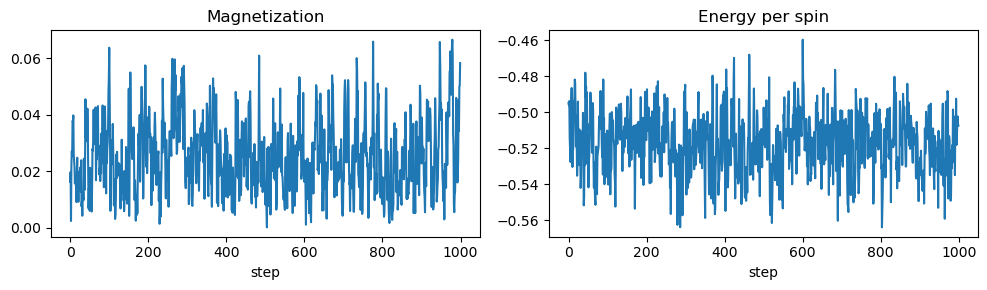

In [11]:
# --- Cell 6: plot time series ---
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(Ms); ax[0].set_title("Magnetization"); ax[0].set_xlabel("step")
ax[1].plot(Es); ax[1].set_title("Energy per spin"); ax[1].set_xlabel("step")
plt.tight_layout()
plt.show()
